In [ ]:
%%capture
!pip install pyLDAvis==3.4.1
!pip install datasets==3.2.0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
import pandas as pd
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pyLDAvis
import pyLDAvis.lda_model

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

dataset = load_dataset("databricks/databricks-dolly-15k", split="train")
df = dataset.to_pandas()
df['instruction'].head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,instruction
0,When did Virgin Australia start operating?
1,Which is a species of fish? Tope or Rope
2,Why can camels survive for long without water?
3,"Alice's parents have three daughters: Amy, Jes..."
4,When was Tomoaki Komorida born?


In [ ]:
print(df['instruction'].duplicated().sum())
df.drop_duplicates(subset=['instruction'], inplace=True)
print(df['instruction'].duplicated().sum())

232
0


In [ ]:
print(df.isna().sum().sum())
df['instruction'] = df['instruction'].apply(lambda x: x.strip())

0


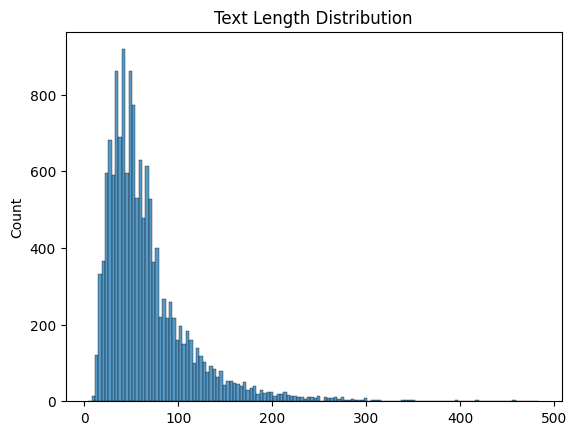

In [ ]:
ax = sns.histplot(df.loc[df['instruction'].apply(len) < 500],
                  x=df.loc[df['instruction'].apply(len) < 500]['instruction'].apply(len));
ax.set_title('Text Length Distribution');
ax.set_xlabel(None);

In [ ]:
def tokenize(text: str) -> list:
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return lemmas

In [ ]:
count_vect = CountVectorizer(stop_words=stopwords.words('english'),
                             tokenizer=tokenize, lowercase=True)
x_counts = count_vect.fit_transform(df['instruction'].to_list())
tf_idf = TfidfTransformer()
x_tf_idf = tf_idf.fit_transform(x_counts)

In [ ]:
lda = LDA(n_components=8, n_jobs=-1)
lda_array = lda.fit_transform(x_tf_idf)

In [ ]:
components = [lda.components_[i] for i in range(len(lda.components_))]
features = list(count_vect.get_feature_names_out())
topic_related_words = [sorted(features, key=lambda x: components[j][features.index(x)], reverse=True)[:15] for j in range(len(components))]

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, x_counts, count_vect, mds='tsne')
pyLDAvis.display(panel)